Based on Implementation from:
https://www.tensorflow.org/tutorials/generative/cyclegan

Using Generator based on the cycleganPaper.

Now Using synthetic images with midstate-digits.

In [1]:
# add parent dir to syspath
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

# Imports 

In [2]:
# own imports
from models.cyclegan_modified.cyclegan import cyclegan
#from models import image_preprocessing
from imageGenerators import load_digits, load_realdata
from imageGenerators.imgGen_simple import synth_generator

import models.common_functions 
# librarys
import tensorflow as tf
import cv2
from pathlib import Path
from matplotlib import pyplot as plt
from os import listdir, mkdir
import os
import numpy as np
import time
import pickle
import random

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
# assert model is running on gpu
from tensorflow.python.client import device_lib
devlist = str(device_lib.list_local_devices())
assert "GPU:0" in devlist

# Parameters 

In [4]:
N_IMAGES = 500
EPOCHS = 4
N_TEST = 5
N_DIGITS = 5
BATCH_SIZE = 1
BUFFER_SIZE = 1000

# all images will be resized to these dimensions
#                  width, height
IMAGE_DIMENSIONS = (512, 128)
# whether to train on images with channel==1, or 3
GRAYSCALE = False
N_CHANNELS = 1 if GRAYSCALE else 3

#              height,              width,               channels
IMAGE_SHAPE = (IMAGE_DIMENSIONS[1], IMAGE_DIMENSIONS[0], N_CHANNELS)

CHECKPOINTPATH = Path("D:/m2/savedmodels/checkpoints_cyclegan_modified_midstate4")

# generate synthetic images (Domain A)

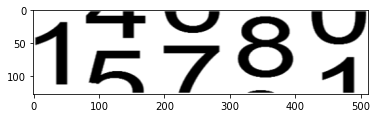

In [6]:
# path to the char74k datset
datasetPath = Path("C:/Users/andre/Desktop/m/datasets/Chars74K/English/Fnt")
# make list mapping integers to list of images of that digit: 
digitImages = load_digits.load_char74k(datasetPath, fonts=[28]) # use a font that is close to the datasets
# init imagegenerator
synthGenerator = synth_generator(digitImages, vertical_margin=20)

# how far can a digit be scrolled down for it to be considered midstate/normalstate
midstate_range=(0.3,0.7) # scrolling down so much that two digits are on screen
normalstate_range=(-0.2,0.2) # scrolling up or down a little keeps normalstate

# prepare inputdigits 
digitsTrain = np.random.randint(0,20,size=(N_IMAGES, N_DIGITS))
digitsTest = np.random.randint(0,20,size=(N_TEST, N_DIGITS))

# params to imagegenerator
margins = [20 for _ in range(0, N_DIGITS - 1)] # distances between digits
border = (2, 2, 2, 2) # padding of resultimage
height = IMAGE_DIMENSIONS[1]; width= IMAGE_DIMENSIONS[0] # dimensions to resize result to
# generate images
synthTrain = synthGenerator.generate_images(digitsTrain, margins, border, width, height, range_normal=normalstate_range,range_midstate=midstate_range)
synthTest = synthGenerator.generate_images(digitsTest, margins, border, width, height, range_normal=normalstate_range,range_midstate=midstate_range)

plt.imshow(synthTrain[0], cmap='gray')
plt.show()

[ 1 14 16  8 10]


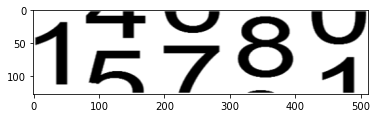

[ 5 17  6 13  5]


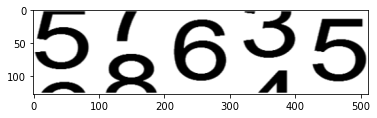

[19 19 12  5 12]


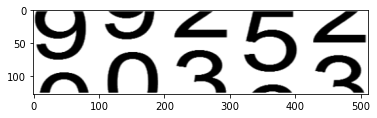

[ 1 16  2 12  1]


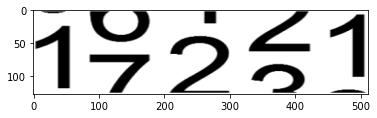

[ 9  1 14 11  2]


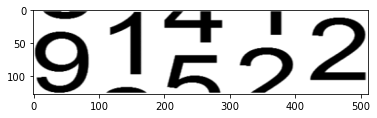

[ 6  9 14 10 12]


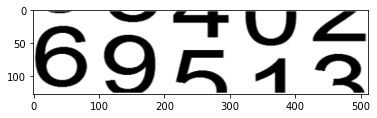

[14 10  7 19  3]


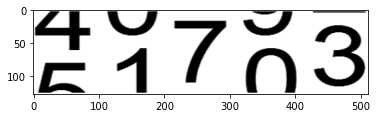

[14 13  9  7 11]


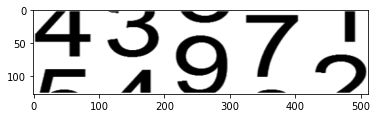

[ 7 15  3 13  3]


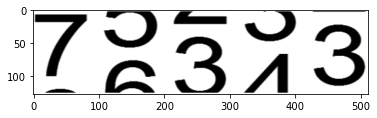

[14 13  2 11 15]


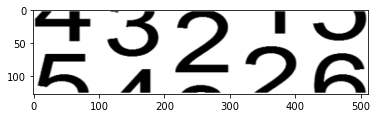

[17  7  2  9  1]


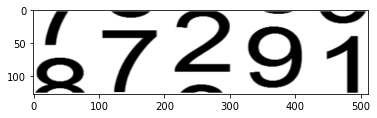

[ 6  1  5  9 17]


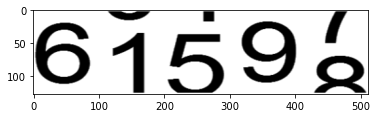

[11 15  8  6  0]


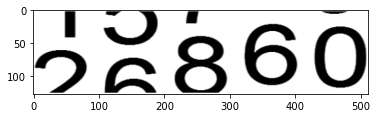

[15 16  8  2 17]


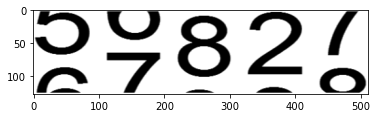

[ 6 12  4  5  5]


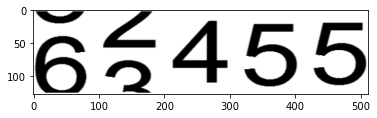

[19  6 18  1  0]


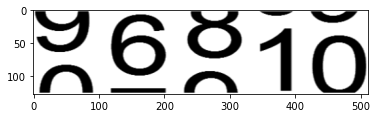

[ 1  8 16  8 13]


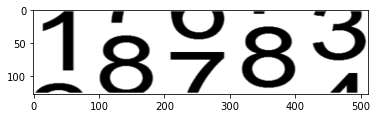

[18 19  2  1 12]


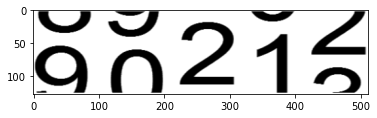

[ 0 13 12 10 19]


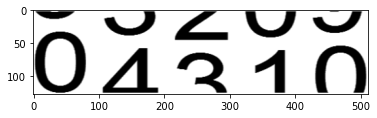

[ 3 18 11 11  7]


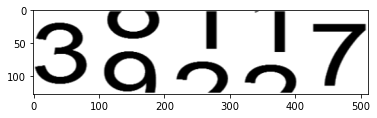

In [7]:
for i in range(20):
    image = synthTrain[i]
    print(digitsTrain[i])
    plt.imshow(image.astype(int), cmap="gray")
    plt.show()

# load real images (Domain B)

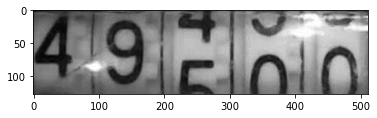

In [6]:
# path to watermeterdataset
wmr_path = Path("C:/Users/andre/Desktop/m/datasets/SCUT-WMN DataSet/easy_samples")
# load random images from dataset, along with the paths used.
# Also resizes images to targetdimensions
real, paths_used = load_realdata.load_wmr(wmr_path, n_images=(N_IMAGES + N_TEST), resize_to=IMAGE_DIMENSIONS)
realTrain = real[0:N_IMAGES]
realTest = real[N_IMAGES:-1]

plt.imshow(realTrain[0], cmap='gray')
plt.show()

# save used images (to continue training)

In [7]:
traindatapath = CHECKPOINTPATH / "traindata.pickle"
if traindatapath.exists():
    # reload old dataset to resume training
    with open(savepath, "rb") as picklefile:
        synthTrain, synthTest, realTrain, realTest, digitsTest = pickle.load(picklefile)
else:
    # save dataset
    dataset = (synthTrain, synthTest, realTrain, realTest, digitsTest)
    with open(savepath, "wb") as picklefile:
        pickle.dump(dataset, picklefile, pickle.HIGHEST_PROTOCOL)

# Preprocess inputs

In [9]:
# make tf-Datasets
train_A = tf.data.Dataset.from_tensor_slices(synthTrain)
train_B = tf.data.Dataset.from_tensor_slices(realTrain)
test_A = tf.data.Dataset.from_tensor_slices(synthTest)
test_B = tf.data.Dataset.from_tensor_slices(realTest)
# define preprocessing operations
def preprocess(imageTensor):
    # reshape (h,w) -> (h,w,1)
    imageTensor = tf.reshape(imageTensor, (imageTensor.shape[0], imageTensor.shape[1], 1))
    if(not GRAYSCALE):
        # duplicate last dimension
        imageTensor = tf.repeat(imageTensor, 3, axis=-1) # should be the same as cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    # to float
    imageTensor = tf.cast(imageTensor, tf.float32)
    # normalize
    imageTensor = (imageTensor / 127.5) - 1
    return imageTensor
# apply preprocessing, cache and batch (data already shuffled)
train_A = train_A \
        .map(preprocess, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(1)
test_A = test_A \
        .map(preprocess, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(1)
train_B = train_B \
        .map(preprocess, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(1)
test_B = test_B \
        .map(preprocess, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(1)

# load model

In [10]:
cgModel = cyclegan(IMAGE_SHAPE, checkpoint_path=CHECKPOINTPATH)
cgModel.gen_AtoB.summary()

loaded checkpoint:  D:\m2\savedmodels\checkpoints_cyclegan_modified_midstate3\epoch-4
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 512, 3) 0                                            
__________________________________________________________________________________________________
reflection_padding2d (Reflectio (None, 134, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 512, 64) 9472        reflection_padding2d[0][0]       
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 128, 512, 64) 128         conv2d[0][0]                     
________

In [11]:
cgModel.train(train_A, train_B, test_A, n_testimages=N_TEST, epochs=EPOCHS, epochs_before_save=2)

KeyboardInterrupt: 